In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Exercise 1

In [2]:
#Set the random seed to 0
np.random.seed(0)
#Load the data
data = pd.read_csv('meatspec.csv')
X = data.drop('fat', axis=1)
y = data['fat']
print (X.head())
print (y.head())

        V1       V2       V3       V4       V5       V6       V7       V8  \
0  2.61776  2.61814  2.61859  2.61912  2.61981  2.62071  2.62186  2.62334   
1  2.83454  2.83871  2.84283  2.84705  2.85138  2.85587  2.86060  2.86566   
2  2.58284  2.58458  2.58629  2.58808  2.58996  2.59192  2.59401  2.59627   
3  2.82286  2.82460  2.82630  2.82814  2.83001  2.83192  2.83392  2.83606   
4  2.78813  2.78989  2.79167  2.79350  2.79538  2.79746  2.79984  2.80254   

        V9      V10  ...      V91      V92      V93      V94      V95  \
0  2.62511  2.62722  ...  3.00247  2.98145  2.96072  2.94013  2.91978   
1  2.87093  2.87661  ...  3.30473  3.29186  3.27921  3.26655  3.25369   
2  2.59873  2.60131  ...  2.70934  2.68951  2.67009  2.65112  2.63262   
3  2.83842  2.84097  ...  2.99820  2.97367  2.94951  2.92576  2.90251   
4  2.80553  2.80890  ...  3.32201  3.30025  3.27907  3.25831  3.23784   

       V96      V97      V98      V99     V100  
0  2.89966  2.87964  2.85960  2.83940  2.81920  


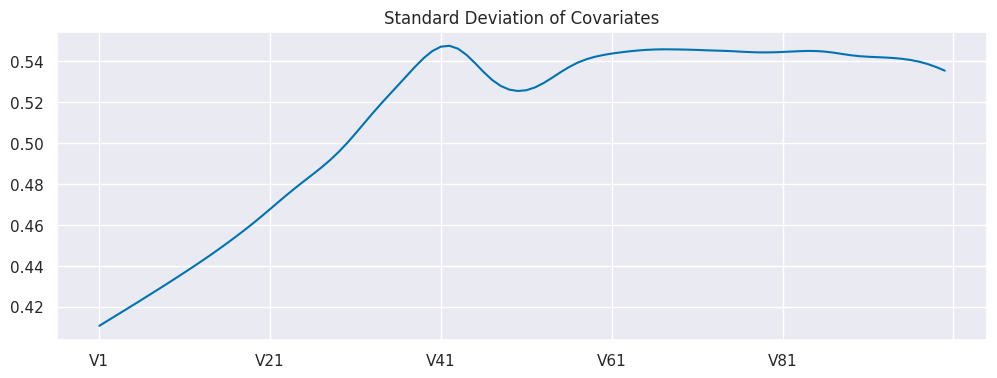

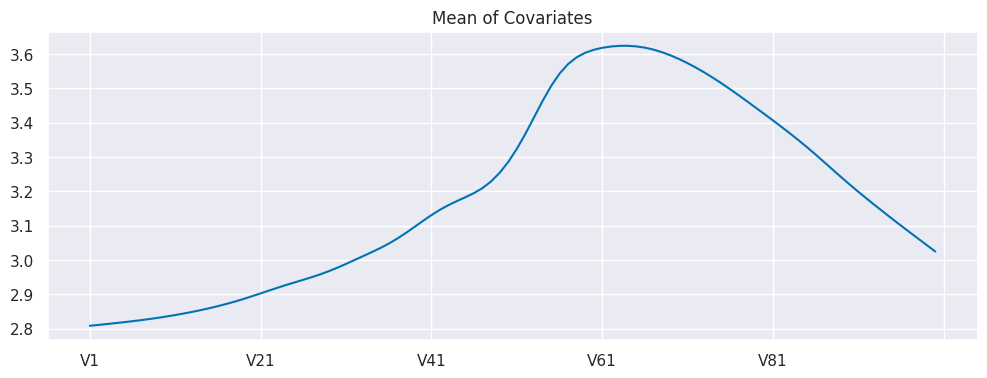

In [12]:
#Print the mean, and standard deviation of every covariate. Is the data centered? Normalized? Standardized?
sns.set(style='darkgrid', palette='colorblind')
mean = X.mean()
std = X.std()

std.plot(title='Standard Deviation of Covariates', figsize= (12, 4))
plt.show()
mean.plot(title='Mean of Covariates', figsize=(12, 4))
plt.show()

The data is not centered, since the mean is not zero, as we can see from the graph plotted above. Also, the data is not normalized, since the mean is not between 0 and 1, even though the standard deviation is. Finally, the data is not standardized, since the mean is not 0 and the standard deviation is not 1.

In [51]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

#Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [52]:
# OLS Regression
# It is not necessary to fit the intercept term in this case, since the data is already centered.

reg = LinearRegression(fit_intercept=False)
reg2 = LinearRegression(fit_intercept=True)
reg.fit(X_train_scaled, y_train_scaled)
reg2.fit(X_train_scaled, y_train_scaled)
yhat = reg.predict(X_test_scaled)
yhat2 = reg2.predict(X_test_scaled)
r2 = r2_score(y_test_scaled, yhat)
r2_2 = r2_score(y_test_scaled, yhat2)

print('Result without fitting the intercept: ' + str(r2))
print('Result fitting the intercept: ' + str(r2_2))

df_coef_test = {'R2_ex1': [r2]}
df_coef_train = {'R2_ex1': [
    r2_score(y_train_scaled, reg.predict(X_train_scaled))]}

Result without fitting the intercept: 0.9489651420152788
Result fitting the intercept: 0.9489651420159662


In [53]:
#get p values of the coefficients 
from scipy import stats
p_values = [stats.t.sf(np.abs(i), len(X_train_scaled)-1)*2 for i in reg.coef_]

As we can see, the results without fitting and fitting the intercept are close enough to define that they are the same.

# Exercise 2

In [54]:
def forward_variable_selection(X, Y):
    y_2 = np.copy(Y)
    var = []
    p = []
    # At each step we will select one variable to add to our list
    for a in range(X.shape[1]):
        final_thetas = []
        T = []
        # going through all variables to search for largest T/smallest p-value
        for i in range(X.shape[1]):
            if (i not in var):
                # fitting model using only one covariate at a time
                reg = LinearRegression(fit_intercept=True)
                reg.fit(X[:, i].reshape(-1, 1), y_2)

                theta = np.array([reg.intercept_, reg.coef_[0]])
                final_thetas.append(theta)

                # calculating Gram matrix, noise and s
                buf = np.c_[np.ones(X.shape[0]), X[:, i]]
                Gram = buf.T @ buf / X.shape[0]
                noise = np.linalg.norm(
                    y_2 - buf @ theta, ord=2)**2 / (X.shape[0]-2)
                s = np.dot(
                    np.dot(np.array([0, 1]).T, np.linalg.inv(Gram)), np.array([0, 1]))
                # using values to calculate T
                t = np.sqrt(X.shape[0]) * np.linalg.norm(theta,
                                                         ord=1)/np.sqrt(noise * s)
                T.append(float(t))
            else:
                final_thetas.append(np.array([0, 0]))
                T.append(0)
        # the selected variable at each step will have the largest T
        # append it to the variables
        p.append(2*stats.t.sf(np.abs(max(T)), len(X)-1))
        sel = T.index(max(T))
        var.append(sel)
        # replacing the output Y by the residual
        y_2 -= np.c_[np.ones(X.shape[0]), X[:, sel]] @ final_thetas[sel]

    return var, p


In [55]:
var, p = forward_variable_selection(X_train_scaled, y_train_scaled)

List of variable selections: [40, 6, 39, 7, 41, 8, 38, 5, 42, 9, 37, 4, 36, 10, 43, 3, 35, 11, 34, 2, 44, 1, 97, 12, 33, 0, 96, 13, 98, 14, 32, 15, 95, 16, 99, 63, 31, 17, 45, 64, 94, 62, 93, 65, 92, 18, 30, 66, 91, 67, 90, 61, 46, 68, 89, 60, 88, 19, 29, 69, 87, 53, 86, 54, 85, 59, 28, 55, 84, 70, 83, 52, 47, 58, 82, 56, 27, 20, 81, 57, 26, 71, 80, 51, 48, 72, 25, 21, 79, 73, 24, 50, 78, 74, 23, 75, 77, 22, 49, 76]
Covariates that are significant at p=0.05: [40, 6, 39, 7, 41]


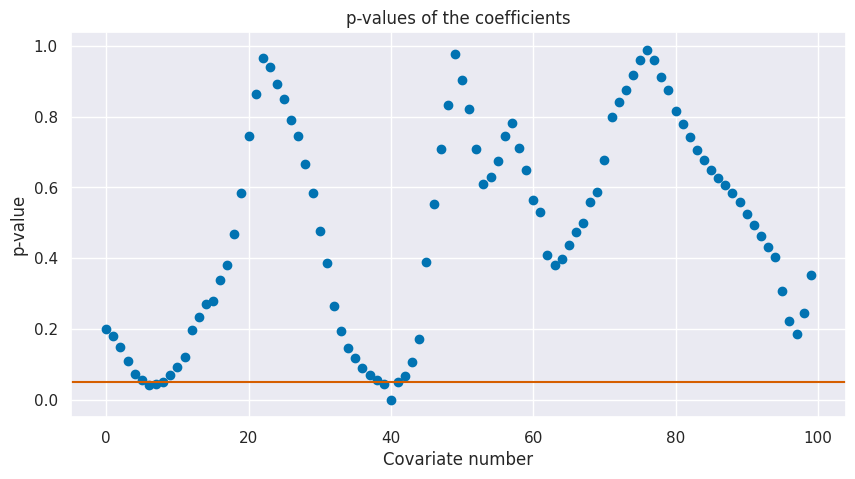

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(var, p, 'o')
plt.xlabel('Covariate number')
plt.ylabel('p-value')
plt.title('p-values of the coefficients')
#plot a horizontal line at p=0.05
plt.axhline(y=0.05, color='r', linestyle='-')
#print the covariates that are significant at p=0.05
print ('List of variable selections: ' + str(var))
selected_var = [i for i in var if p[var.index(i)] < 0.05]
print ('Covariates that are significant at p=0.05: ' + str(selected_var))

# Exercise 3

In [11]:
# OLS Regression
# It is not necessary to fit the intercept term in this case, since the data is already centered.

reg = LinearRegression()
reg.fit(X_train_scaled[:, selected_var], y_train_scaled)
yhat = reg.predict(X_test_scaled[:, selected_var])

r2 = r2_score(y_test_scaled, yhat)

print('Result without fitting the intercept: ' + str(r2))

df_coef_test['R2_ex3'] = [r2]
df_coef_train['R2_ex3'] = [
    r2_score(y_train_scaled, reg.predict(X_train_scaled[:, selected_var]))]

Result without fitting the intercept: 0.9332559970952955


# Exercise 4

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(LinearRegression(
), n_features_to_select=len(selected_var), direction='forward')
sfs.fit(X_train_scaled, y_train_scaled)
print('Selected features: %s' % list(sfs.get_support(indices=True)))


Selected features: [7, 36, 40, 46, 99]


In [13]:
selected = sfs.get_support(indices=True).tolist()
# train model
reg = LinearRegression()
reg.fit(X_train_scaled[:, selected], y_train_scaled)
yhat = reg.predict(X_test_scaled[:, selected])

r2 = r2_score(y_test_scaled, yhat)

print('Result with the selected variables: ' + str(r2))

df_coef_test['R2_ex4'] = [r2]
df_coef_train['R2_ex4'] = [
    r2_score(y_train_scaled, reg.predict(X_train_scaled[:, selected]))]


Result with the selected variables: 0.9409902052880621


According to sklearn's documentation: Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero features and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the n_features_to_select parameter.

From the documentation, we can see that the sklearn's implementation performs a cross validation in order to maximize the score. Our implementation did not use a cross validation, so the result found by sklearn is normally able to generalize better to the test set. That makes sense when we compare the results of the two implementations, since the sklearn's implementation has a better score on the test set. Besides, it maximizes the score, instead of getting the smallest p-values, so it was expected to have a different result.

# Exercise 5

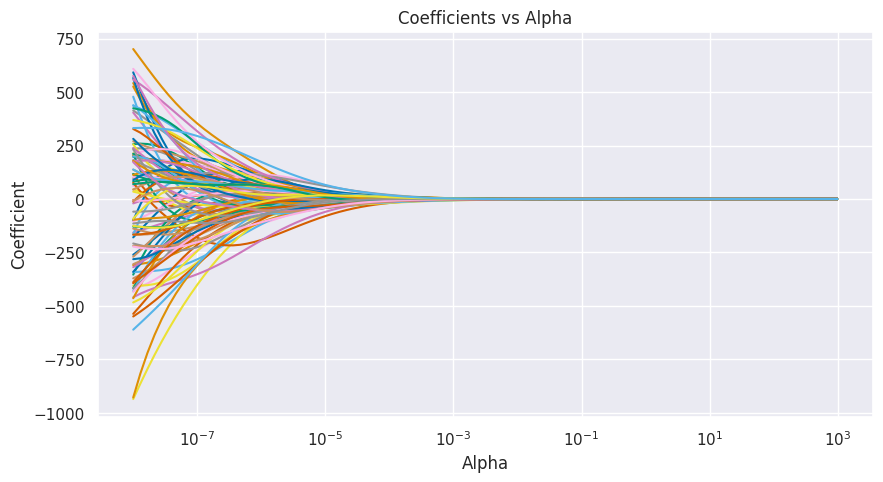

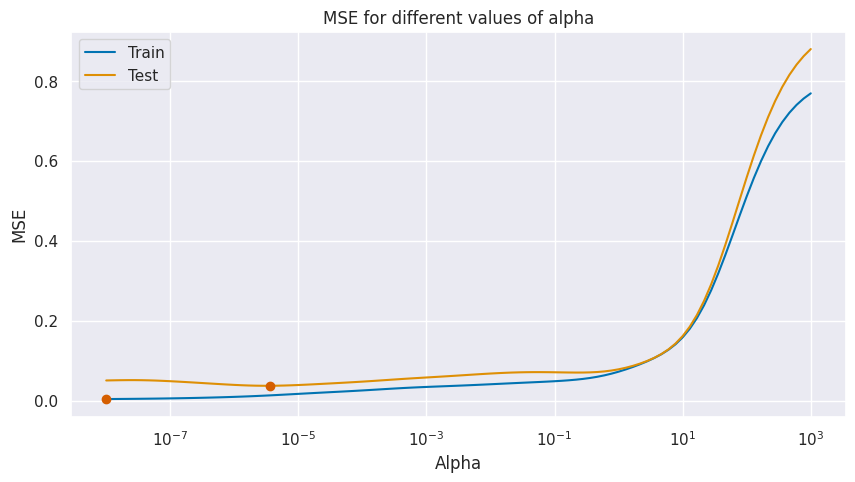

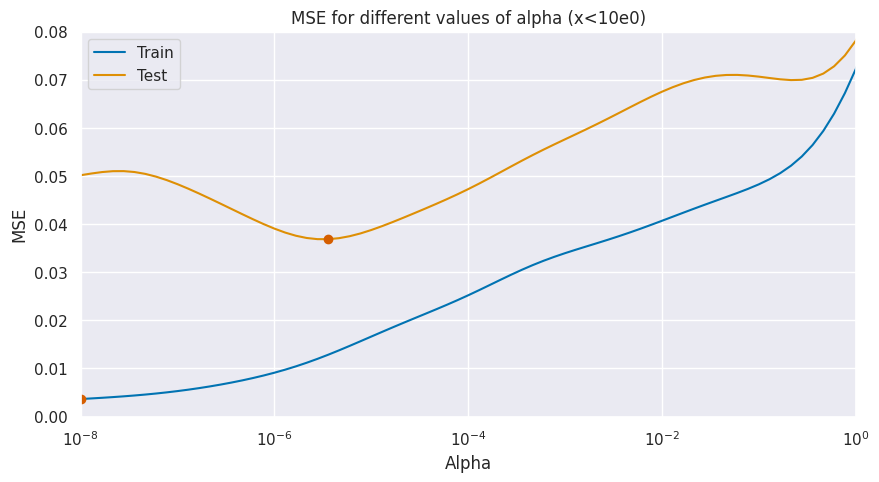

In [14]:
def ridge(X, y, alpha):
    # using the formula found in the material
    theta = np.linalg.inv(X.T @ X + alpha * np.identity(X.shape[1])) @ X.T @ y
    return theta


# calculating the coefficients for different values of alpha
alphas = np.logspace(-8, 3, 100)  # between 10e-9 and 10e2
thetas = []
for a in alphas:
    thetas.append(ridge(X_train_scaled, y_train_scaled, a))
# Plot how the values of the coefficients change with α.

plt.figure(figsize=(10, 5))
for i in range(len(thetas[0])):
    plt.plot(alphas, [theta[i] for theta in thetas])
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient')
    plt.xscale('log')
    plt.title('Coefficients vs Alpha')
plt.show()


# calculating the MSE for different values of alpha
MSE_train = []
MSE_test = []
for a in alphas:
    theta = ridge(X_train_scaled, y_train_scaled, a)
    yhat_train = X_train_scaled @ theta
    yhat_test = X_test_scaled @ theta
    MSE_train.append(mean_squared_error(y_train_scaled, yhat_train))
    MSE_test.append(mean_squared_error(y_test_scaled, yhat_test))
# plotting the MSE for different values of alpha
plt.figure(figsize=(10, 5))
plt.plot(alphas, MSE_train, label='Train')
plt.plot(alphas, MSE_test, label='Test')
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('MSE')
plt.title('MSE for different values of alpha')
plt.legend()
# plotting the minimum of the MSE for different values of alpha
plt.plot(alphas[MSE_test.index(min(MSE_test))], min(MSE_test), 'o', color='r')
plt.plot(alphas[MSE_train.index(min(MSE_train))],
         min(MSE_train), 'o', color='r')
plt.show()

# plot again but limiting x to 10e0
plt.figure(figsize=(10, 5))
plt.plot(alphas, MSE_train, label='Train')
plt.plot(alphas, MSE_test, label='Test')
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('MSE')
plt.title('MSE for different values of alpha (x<10e0)')
plt.legend()

# plotting the minimum of the MSE for different values of alpha
plt.plot(alphas[MSE_test.index(min(MSE_test))], min(MSE_test), 'o', color='r')
plt.plot(alphas[MSE_train.index(min(MSE_train))],
         min(MSE_train), 'o', color='r')
plt.xlim(1e-8, 1)
plt.ylim(0, 0.08)
plt.show()

When we plot the Ridge until 10e0, we can see that it is what we expected, the test MSE decreases at first and starts to increase after the optimal value of alpha

In [15]:
#predicting the test set using the best value of alpha
theta = ridge(X_train_scaled, y_train_scaled,
              alphas[MSE_test.index(min(MSE_test))])
yhat_test = X_test_scaled @ theta
r2 = r2_score(y_test_scaled, yhat_test)
print('Alpha for the best performing value of alpha: ' +
      str(alphas[MSE_test.index(min(MSE_test))]))
print('R2 for the best performing value of alpha: ' + str(r2))

df_coef_test['R2_ex5'] = [r2]
df_coef_train['R2_ex5'] = [r2_score(y_train_scaled, X_train_scaled @ theta)]


Alpha for the best performing value of alpha: 3.5938136638046257e-06
R2 for the best performing value of alpha: 0.968861029258133


# Exercise 6

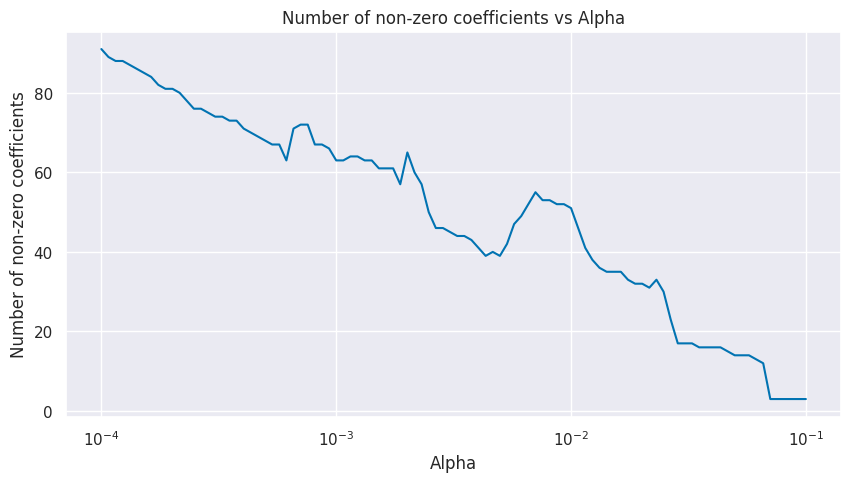

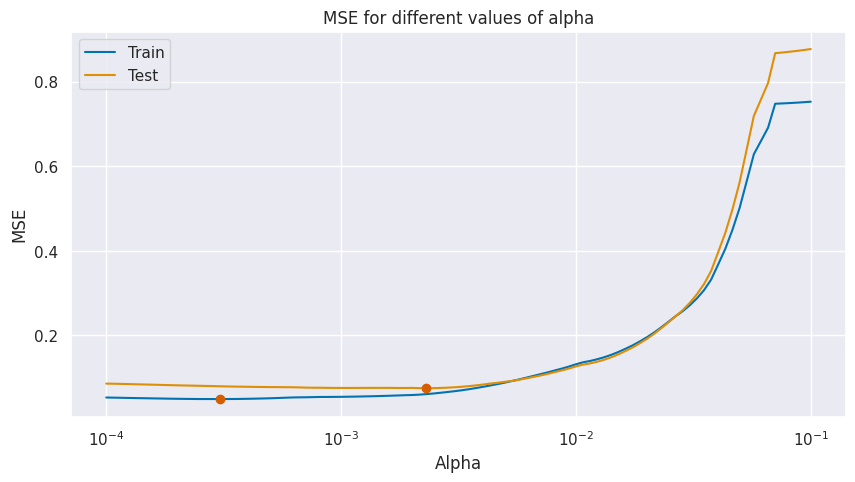

In [57]:
from sklearn.linear_model import Lasso
alphas = np.logspace(-4, -1, 100)
thetas = []
for a in alphas:
    lasso = Lasso(alpha=a, tol=0.03, max_iter=10000)
    lasso.fit(X_train_scaled, y_train_scaled)
    thetas.append(lasso.coef_)

# Plot the number of coefficients that are different from 0 for each value of α.
plt.figure(figsize=(10, 5))
plt.plot(alphas, [np.count_nonzero(t) for t in thetas])
plt.xlabel('Alpha')
plt.ylabel('Number of non-zero coefficients')
plt.xscale('log')
plt.title('Number of non-zero coefficients vs Alpha')

# Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.
MSE_train = []
MSE_test = []
for a in alphas:
    lasso = Lasso(alpha=a, tol=0.03, max_iter=10000)
    lasso.fit(X_train_scaled, y_train_scaled)
    yhat_train = lasso.predict(X_train_scaled)
    yhat_test = lasso.predict(X_test_scaled)
    MSE_train.append(mean_squared_error(y_train_scaled, yhat_train))
    MSE_test.append(mean_squared_error(y_test_scaled, yhat_test))
plt.figure(figsize=(10, 5))
plt.plot(alphas, MSE_train, label='Train')
plt.plot(alphas, MSE_test, label='Test')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE for different values of alpha')
plt.legend()
plt.plot(alphas[MSE_test.index(min(MSE_test))], min(MSE_test), 'o', color='r')
plt.plot(alphas[MSE_train.index(min(MSE_train))],
         min(MSE_train), 'o', color='r')
plt.xscale('log')


In [17]:
# predict the test set using the best value of alpha
lasso = Lasso(alpha=alphas[MSE_test.index(
    min(MSE_test))], tol=0.03, max_iter=10000)
lasso.fit(X_train_scaled, y_train_scaled)
yhat_test = lasso.predict(X_test_scaled)
r2 = r2_score(y_test_scaled, yhat_test)
print('Alpha for the best performing value of alpha: ' +
      str(alphas[MSE_test.index(min(MSE_test))]))
print('R2 for the best performing value of alpha: ' + str(r2))

df_coef_test['R2_ex6'] = [r2]
df_coef_train['R2_ex6'] = [
    r2_score(y_train_scaled, lasso.predict(X_train_scaled))]


Alpha for the best performing value of alpha: 0.0023101297000831605
R2 for the best performing value of alpha: 0.9366977602910387


Increasing max_iter can help the model to converge to the optimal value of alpha, since it train the model more times, while the tolerance indicates when the algorithm should stop. If the values used are not ideal, the algorithm won't converge and the results will not be satisfactory. We can also observe that the number of non-zero parameters decrease with the increase of alpha, which is expected, since the model is penalized more and more as alpha increases.

# Exercise 7

In [18]:
from sklearn.linear_model import ElasticNet
import tqdm

def cross_validation(X, y, n_folds, alpha_ridge, alpha_lasso):
    # splitting the data in n_folds
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    # creating the list of thetas
    thetas = []
    # creating the list of the MSE
    MSE = []
    # creating the list of the R2
    R2 = []

    # looping over the folds
    for i in range(n_folds):
        # creating the test set
        X_test = X_folds[i]
        y_test = y_folds[i]
        # creating the train set
        X_train = np.concatenate([X_folds[j]
                                 for j in range(n_folds) if j != i])
        y_train = np.concatenate([y_folds[j]
                                 for j in range(n_folds) if j != i])
        # standardizing the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = scaler.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler.transform(y_test.reshape(-1, 1))

        # fitting the model
        elastic = ElasticNet(
            alpha=alpha_ridge, l1_ratio=alpha_lasso, tol=0.1, max_iter=100000)
        elastic.fit(X_train, y_train)
        # calculating the MSE
        yhat_test = elastic.predict(X_test)
        MSE.append(mean_squared_error(y_test, yhat_test))
        # calculating the R2
        R2.append(r2_score(y_test, yhat_test))
    return np.mean(MSE), np.mean(R2)

# creating the list of the alphas
alphas_ridge = np.logspace(-9, 4, 100)
# creating the list of the l1_ratios
l1_ratios = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
# l1_ratios = [0]
# creating the list of the MSE
MSE = []
# creating the list of the R2
R2 = []
# creating the list of the number of non-zero coefficients
# looping over the alphas
for l in tqdm.tqdm(l1_ratios):
    # looping over the l1_ratios
    for a in alphas_ridge:
        # calculating the MSE, R2 and the number of non-zero coefficients
        MSE_, R2_ = cross_validation(X_train_scaled, y_train_scaled, 5, a, l)
        # appending the results
        MSE.append(MSE_)
        R2.append(R2_)

  0%|          | 0/7 [00:00<?, ?it/s]/home/luizf/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+01, tolerance: 1.280e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/luizf/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+01, tolerance: 1.290e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using 

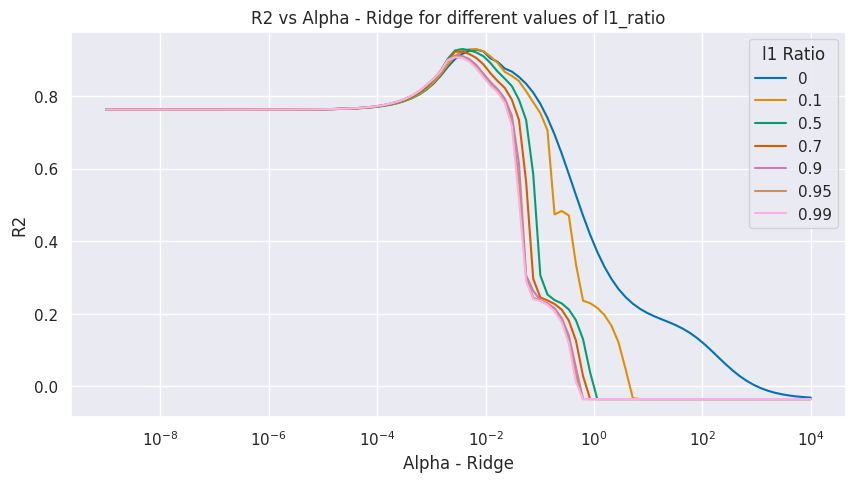

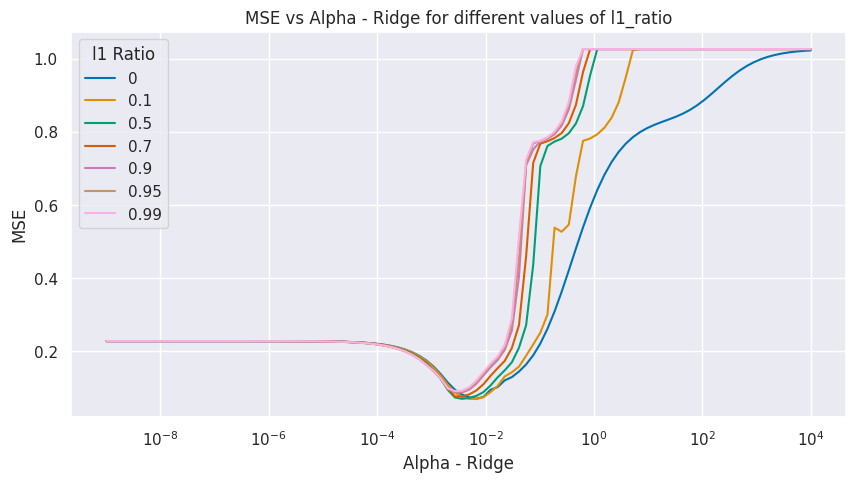

In [19]:
# plotting the results
plt.figure(figsize=(10, 5))
# plot one curve for each value of l1_ratio
for i in range(len(l1_ratios)):
    plt.plot(alphas_ridge, R2[i*len(alphas_ridge):(i+1) *
             len(alphas_ridge)], label='l1_ratio = ' + str(l1_ratios[i]))
plt.legend(l1_ratios, title='l1 Ratio')
plt.title('R2 vs Alpha - Ridge for different values of l1_ratio')
plt.xlabel('Alpha - Ridge')
plt.ylabel('R2')
plt.xscale('log')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(l1_ratios)):
    plt.plot(alphas_ridge, MSE[i*len(alphas_ridge):(i+1) *
             len(alphas_ridge)], label='l1_ratio = ' + str(l1_ratios[i]))

plt.legend(l1_ratios, title='l1 Ratio')
plt.xlabel('Alpha - Ridge')
plt.title('MSE vs Alpha - Ridge for different values of l1_ratio')
plt.ylabel('MSE')
plt.xscale('log')
plt.show()


In [60]:
# Get the values of alpha and l1_ratio that minimizes MSE
best_alpha_ridge = alphas_ridge[np.argmin(MSE) % len(alphas_ridge)]
best_l1_ratio = l1_ratios[np.argmin(MSE) // len(alphas_ridge)]
print('Best alpha: ' + str(best_alpha_ridge))
print('Best l1_ratio for ElasticNet: ' + str(best_l1_ratio))
print('MSE for the best performing value of alpha: ' + str(min(MSE)))


# get the values of alpha and l1_ratio that maximizes R2
best_alpha_ridge = alphas_ridge[np.argmax(R2) % len(alphas_ridge)]
best_l1_ratio = l1_ratios[np.argmax(R2) // len(alphas_ridge)]
print('Best alpha: ' + str(best_alpha_ridge))
print('Best l1_ratio for ElasticNet: ' + str(best_l1_ratio))
print('R2 for the best performing value of alpha: ' + str(max(R2)))


Best alpha: 0.006734150657750828
Best l1_ratio for ElasticNet: 0.1
MSE for the best performing value of alpha: 0.06838124398351562
Best alpha: 0.0036783797718286416
Best l1_ratio for ElasticNet: 0.5
R2 for the best performing value of alpha: 0.9298538338767809


# Exercise 8

Bootstrap
For this question, we are going to use only variable 40 of the dataset original (non-centered) X. Plot
the dataset and the regression line fitted with the whole sample. Generate 50 bootstrap samples,
for each of the samples fit a regression model and plot the 50 estimated regression lines in the same
plot (by setting alpha=.4 in the plotting function you can make the lines more transparent for the
sake of readability of the plot). Finally, in the same plot, plot the prediction intervals (see exercise
12 in the lecture notes for the expression of the confidence intervals for the one dimensional case).

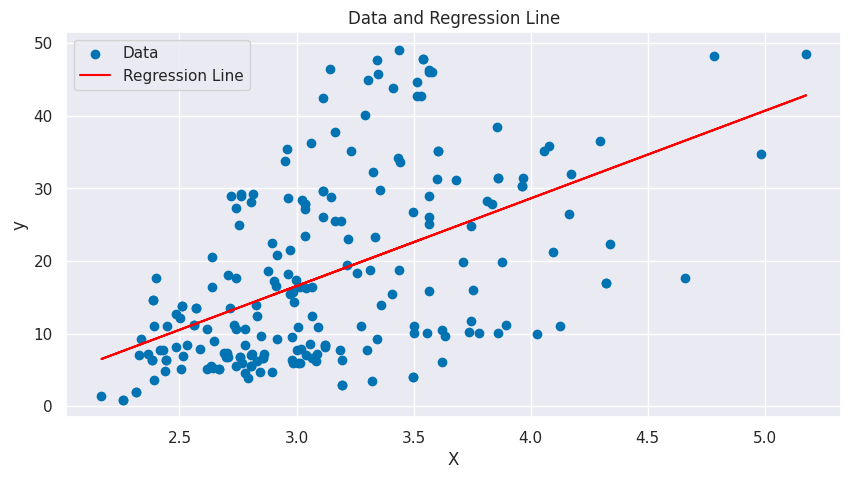

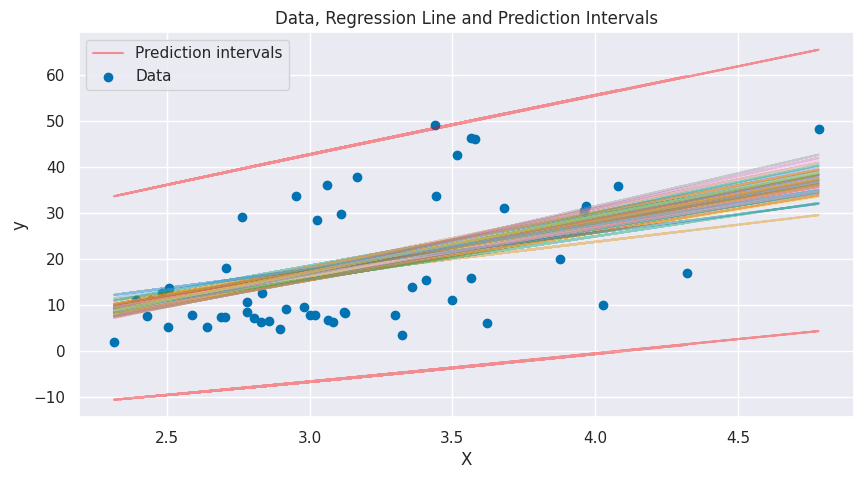

In [21]:
from sklearn.utils import resample
X_train_bootstrap = X_train.values[:, 40]
y_train_bootstrap = y_train.values
X_test_bootstrap = X_test.values[:, 40]
y_test_bootstrap = y_test.values

X_scaled = X.values[:, 40].reshape(-1, 1)
y_scaled = y.values.reshape(-1, 1)

reg = LinearRegression().fit(X_scaled, y_scaled)

# plot data and regression line
plt.figure(figsize=(10, 5))
plt.scatter(X_scaled, y_scaled, label='Data')
plt.plot(X_scaled, reg.predict(X_scaled), color='red', label='Regression Line')
plt.legend()
plt.title('Data and Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

n_samples = 50
models = []

# Generate the bootstrap samples and fit a linear regression model for each sample
for i in range(n_samples):
    X_sample, y_sample = resample(X_train_bootstrap, y_train_bootstrap)
    model = LinearRegression().fit(X_sample.reshape(-1, 1), y_sample)
    models.append(model)

# Plot the regression lines
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(X_test_bootstrap, model.predict(
        X_test_bootstrap.reshape(-1, 1)), alpha=0.4)
plt.xlabel('X')
plt.ylabel('y')

alpha = 0.05
pred_int = []


# Calculate the mean and standard deviation of the predictions from each model
predictions = np.array(
    [model.predict(X_test_bootstrap.reshape(-1, 1)) for model in models])
for pred in predictions:
    # Caculate residual
    residual = y_test.values - pred
    # Caculate variance
    var = 1/(X_train_bootstrap.shape[0]-2) * np.sum(residual**2)
    sigma = np.sqrt(var)
    t = stats.t.ppf(1 - alpha/2, X_train_bootstrap.shape[0]-2)
    # Caculate variance of x
    var_x = np.sum((X_test_bootstrap - np.mean(X_test_bootstrap)) ** 2)
    temp = X_test_bootstrap - np.mean(X_test_bootstrap)**2/var_x
    # Caculate prediction intervals
    lower = pred - t*sigma*(np.sqrt(1+1/len(X_test_bootstrap)+temp))
    upper = pred + t*sigma*(np.sqrt(1+1/len(X_test_bootstrap)+temp))
    pred_int.append((lower, upper))

# Plot the prediction intervals
plt.plot(X_test_bootstrap, lower, color='red',
         alpha=0.4, label='Prediction intervals')
plt.plot(X_test_bootstrap, upper, color='red', alpha=0.4)
plt.xlabel('X')
plt.ylabel('y')
plt.scatter(X_test_bootstrap, y_test_bootstrap, label='Data')
plt.title('Data, Regression Line and Prediction Intervals')
plt.legend()
plt.show()


# Exercise 9

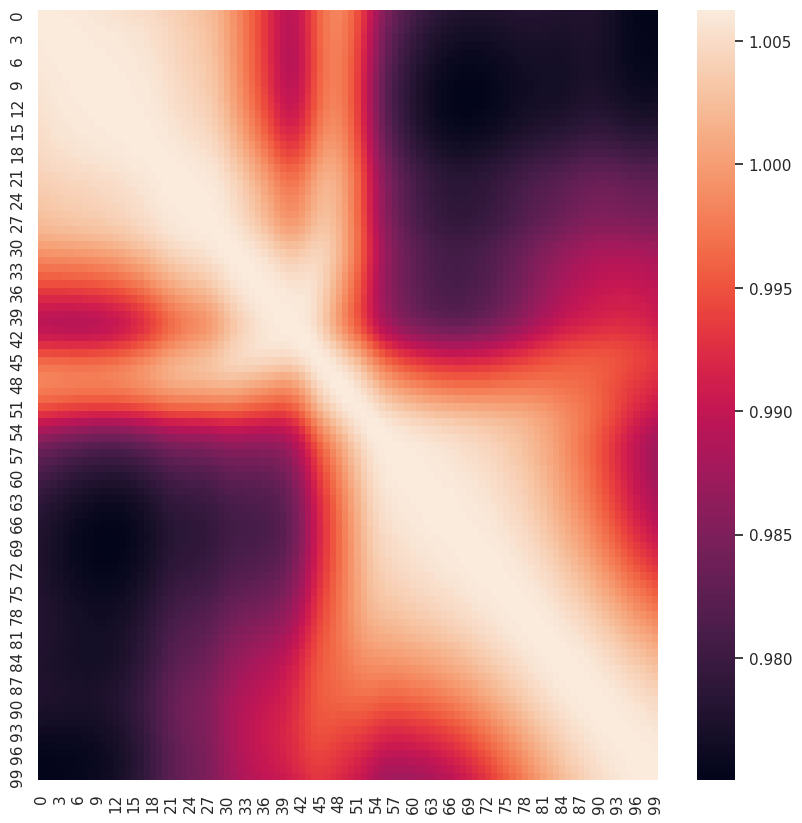

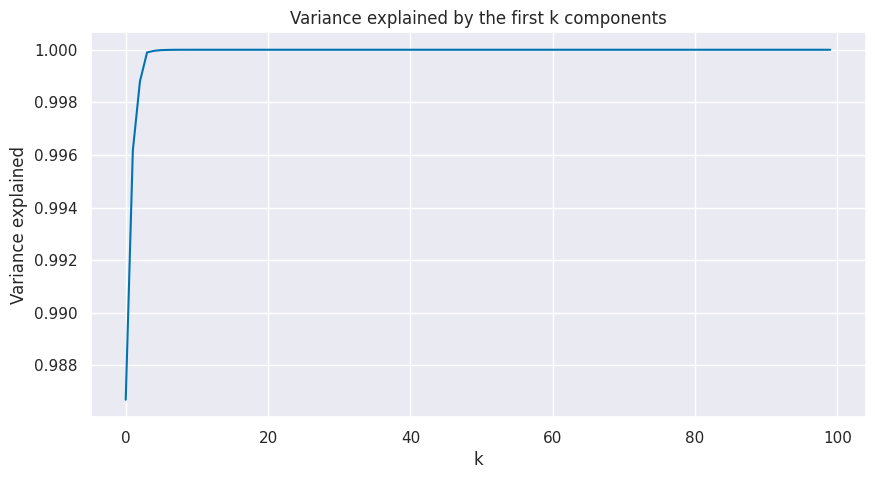

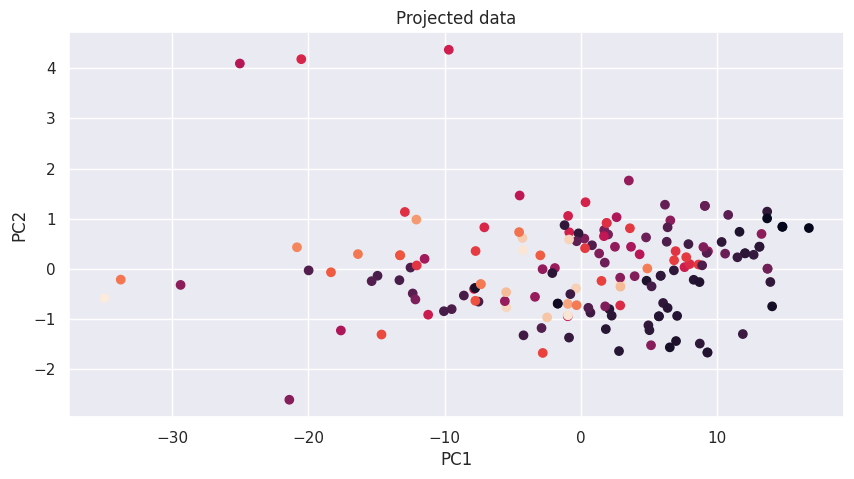

R2 for 2 components: 0.27133522495743023
R2 for 3 components: 0.6561032822164282
R2 for 4 components: 0.9010074987475355
R2 for 5 components: 0.9347126746228477
R2 for 6 components: 0.9378882470288539
R2 for 7 components: 0.9342957746103842
R2 for 8 components: 0.9349808057072388
R2 for 9 components: 0.937009579025368
R2 for 10 components: 0.9398644033170677
R2 for 11 components: 0.9503342158280705
R2 for 12 components: 0.950013169533439
R2 for 13 components: 0.9501682232194666
R2 for 14 components: 0.9509089541930348
R2 for 15 components: 0.950152470295506
R2 for 16 components: 0.9549625907296518
R2 for 17 components: 0.9569760154618636
R2 for 18 components: 0.957619764142772
R2 for 19 components: 0.959140621039902
R2 for 20 components: 0.9551152361463142
R2 for 21 components: 0.9565962548592472
R2 for 22 components: 0.9566212503139699
R2 for 23 components: 0.9570836195266841
R2 for 24 components: 0.9571698638284623
R2 for 25 components: 0.9604126195648455
R2 for 26 components: 0.9619

In [58]:
# Compute the covariance matrix. Compute the singular value decomposition of the covariance
cov = np.cov(X_train_scaled.T)
U, s, V = np.linalg.svd(cov)

# Plot a heatmap of the covariance matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cov)
plt.show()

# Plot the amount of variance explained by the first k components for k in 2..p.
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(s)/np.sum(s))
plt.title('Variance explained by the first k components')
plt.xlabel('k')
plt.ylabel('Variance explained')
plt.show()

# Project the data to the first 2 PCs
X_train_scaled_pca = X_train_scaled.dot(U[:, :2])
X_train_scaled_pca[:, 0] = -X_train_scaled_pca[:, 0]
X_test_scaled_pca = X_test_scaled.dot(U[:, :2])
X_test_scaled_pca[:, 0] = -X_test_scaled_pca[:, 0]

# Plot the projected data
plt.figure(figsize=(10, 5))
plt.scatter(-X_train_scaled_pca[:, 0],
            X_train_scaled_pca[:, 1], c=y_train_scaled)
plt.title('Projected data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Run OLS on the projected data using k components for k evenly spaced in 2..p
r2_pcas_test = []
r2_pcas_train = []
for i in range(2, X.shape[1]):
    X_train_scaled_pca = X_train_scaled.dot(U[:, :i])
    X_test_scaled_pca = X_test_scaled.dot(U[:, :i])
    reg = LinearRegression()
    reg.fit(X_train_scaled_pca, y_train_scaled)
    yhat = reg.predict(X_test_scaled_pca)
    r2_pcas_test.append(r2_score(y_test_scaled, yhat))
    r2_pcas_train.append(
        r2_score(y_train_scaled, reg.predict(X_train_scaled_pca)))


# print the r2 its componentes
for i in range(len(r2_pcas_test)):
    print('R2 for ' + str(i+2) + ' components: ' + str(r2_pcas_test[i]))

best_r2 = max(r2_pcas_test)
best_n_components = r2_pcas_test.index(best_r2) + 2
print('Best R2: ' + str(best_r2))
print('Number of components: ' + str(best_n_components))
r2_train = r2_pcas_train[best_n_components-2]


We can see in the results that the 2 first PCs are not enough to yield a consistent prediction. For more than 11 components, the differences obtained are considerably small, but the best value was found with 91 components. One might want to use less components, since the results are not very diffrent, and it can save some time and memory training.

In [38]:
df_coef_test['R2_ex9'] = best_r2
df_coef_train['R2_ex9'] = r2_train

In [39]:
m = pd.concat([pd.DataFrame(df_coef_train), pd.DataFrame(df_coef_test)], axis=0)
m.index = ['train', 'test']
m

,R2_ex1,R2_ex3,R2_ex4,R2_ex5,R2_ex6,R2_ex9
train,0.997131,0.924186,0.944353,0.987154,0.938978,0.996239
test,0.948965,0.933256,0.940990,0.968861,0.936698,0.966767


# Exercise 10

In the experiments, we were able to see that the R2 obtained with the Ridge was the highest for the test set. Therefore, this regularization method provides the best generalization in this case. Lasso, however, performed poorly, it was worse than the linear regression, possibly due to its characteristic of generating sparse solutions. PCA provided an excelent score, almost as good as the Ridge, and it also reduced the number of features, which is beneficial in order to reduce the training time and avoid the curse of dimensionality. Since it finds the components that explain the most variance, it is able to generate a meaningful space to represent the data without losing too much information, and its result can even be better than the original, as we could see comparing with exercise 1 in terms of generalization.

It is important to note that the results can vary according to the random state used in the train_test_split function, since it is a random process, that is why i needed to set the random state to a value, in order to get reproducible results, since the seed used is different from the one set in numpy. As the questions only specified the seed in the numpy as 0, I used another value for the random state in the train_test_split function.

In this work, we could see in practice how the regularization can solve overfitting, and how it works. It was also possible to observe that the weights tend to 0 as the regularization parameter increases, which is expected, since the regularization is trying to penalize the weights. The elastic net combine both regularizations and can lead to interesting solutions, although the convergence can be difficult sometimes, as I couldn't converge for l1_ratio = 0 and alpha > 10e-2. Using feature selection or PCA to reduce the number of features, we can also avoid the curse of dimensionality and the training time can be reduced, still getting good results. Finally, the ridge is an excelent regularization method, it is extremly simple and can improve significantly the generalization of the model, while we know that lasso is also very useful, but it can lead to sparse solutions, which can be problematic in some cases. It can also be used for feature selection, since it can set some weights to 0, which means that the feature is not important for the model.